##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum advantage in learning from experiments

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_advantage_in_learning_from_experiments"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_advantage_in_learning_from_experiments.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows the experiments of <a target="_blank" href="https://arxiv.org/abs/2112.00778" class="external">Quantum advantage in learning from experiments</a>.

## Setup

In [ ]:
!pip install tensorflow==2.4.1

Install TensorFlow Quantum:

In [ ]:
!pip install tensorflow-quantum

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

Now import TensorFlow and the module dependencies:

In [1]:
import tensorflow as tf
import cirq
import matplotlib.pyplot as plt
import numpy as np
import sympy

## 1. The Basics

We first define the circuit we are going to use to generate samples

In [2]:
def un_bell_pair_block(qubits):
    return [cirq.CNOT(qubits[0], qubits[1]), cirq.H(qubits[0])]

def inv_z_basis_gate(pauli):
    if pauli == "I" or pauli == "Z":
        return cirq.I
    if pauli == "X":
        return cirq.H
    if pauli == "Y":
        # S^dag H to get to computational, H S to go back.
        return cirq.PhasedXZGate(
            axis_phase_exponent=-0.5, x_exponent=0.5, z_exponent=-0.5
        )
    raise ValueError("Invalid Pauli.")
    
def build_circuit(
    qubit_pairs,
    pauli,
    n_shots,
    rand_state):
    a_qubits = [pair[0] for pair in qubit_pairs]
    b_qubits = [pair[1] for pair in qubit_pairs]
    all_qubits = np.concatenate(qubit_pairs)

    flip_params = sympy.symbols(f"param_0:{len(qubit_pairs) * 2}")

    # Add X flips.
    ret_circuit = cirq.Circuit(cirq.X(q) ** p for q, p in zip(all_qubits, flip_params))

    # Add basis turns a and b.
    ret_circuit += [
        inv_z_basis_gate(p)(q) for q, p in zip(a_qubits, pauli)
    ]
    ret_circuit += [
        inv_z_basis_gate(p)(q) for q, p in zip(b_qubits, pauli)
    ]

    # Add un-bell pair.
    ret_circuit += [un_bell_pair_block(pair) for pair in qubit_pairs]

    # Add measurements.
    for i, qubit in enumerate(all_qubits):
        ret_circuit += cirq.measure(qubit, key=f"q{i}")

    # Create randomized flippings. These flippings will contain values of 1,0.
    # which will turn the X gates on or off.
    params = create_randomized_sweeps(
        pauli, flip_params, n_shots, rand_state
    )
    return ret_circuit, params



Then, we create the samples.

In [3]:
def create_randomized_sweeps(
    hidden_p,
    symbols,
    n_params,
    rand_state):
    last_i = 0
    for i, pauli in enumerate(hidden_p):
        if pauli != "I":
            last_i = i

    sign_p = rand_state.choice([1, -1])
    all_sweeps = []
    for _ in range(n_params):
        current_sweep = dict()
        for twocopy in [0, 1]:
            parity = sign_p * rand_state.choice([1, -1], p=[0.95, 0.05])
            for i, pauli in enumerate(hidden_p):
                current_symbol = symbols[2 * i + twocopy]
                current_sweep[current_symbol] = rand_state.choice([0, 1])
                if pauli != "I":
                    if last_i == i:
                        v = 1 if parity == -1 else 0
                        current_sweep[current_symbol] = v
                    elif current_sweep[current_symbol] == 1:
                        parity *= -1

        all_sweeps.append(current_sweep)
    return all_sweeps


We run the code

In [4]:
rand_source = np.random.RandomState(20160913)
n_paulis = 200
n = 3
n_shots = 47
n_sweeps = 1

paulis = np.array(["X", "Y", "Z", "I"])
pauli_strings = rand_source.choice(a=paulis, size=(n_paulis, n), replace=True)

system_pairs = [(cirq.GridQubit(0, i), cirq.GridQubit(1, i)) for i in range(n)]

simulator = cirq.Simulator()

all_results = []
for pauli in pauli_strings:
    circuit, sweeps = build_circuit(system_pairs, pauli, n_shots, rand_source)
    
    results_for_pauli = []
    for b in range(0, n_shots, n_sweeps):
        results = simulator.run_sweep(
            program=circuit,
            params=sweeps[b : b + n_sweeps],
            repetitions=1
        )

        batch_results = []
        for j, single_circuit_samples in enumerate(results):
            qubit_order = [f"q{i}" for i in range(2 * n)]
            out0 = single_circuit_samples.data[qubit_order].to_numpy()
            batch_results.append(np.squeeze(out0))

        batch_results = np.array(batch_results)
        results_for_pauli.append(batch_results)
    all_results.append(np.concatenate(results_for_pauli))
    

In [ ]:
We encode the results so that they can be ingested by our neural network.

In [5]:
def _encode_pauli(paulis):
    encoded = []
    for pauli in paulis:
        if pauli == 'I':
            encoded.extend([0, 0])
        elif pauli == 'X':
            encoded.extend([0, 1])
        elif pauli == 'Y':
            encoded.extend([1, 0])
        elif pauli == 'Z':
            encoded.extend([1, 1])
    return np.asarray([encoded])
    
inputs = []
targets = []
    
for i in range(n_paulis):
    encoded_pauli = np.repeat(_encode_pauli(pauli_strings[i, :]), n_shots, axis=0)
    
    inputs.append(np.expand_dims(np.concatenate((all_results[i], encoded_pauli,), axis=1), axis=0))
    targets.append([1, 0])
    
    inputs.append(np.expand_dims(np.concatenate((all_results[(i + 1) % len(all_results)], encoded_pauli,), axis=1), axis=0))
    targets.append([0, 1])

inputs = np.concatenate(inputs)
targets = np.asarray(targets)

inputs.shape, targets.shape


((400, 47, 12), (400, 2))

We train the model

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu', use_bias=True))
model.add(tf.keras.layers.GRU(4, go_backwards=False, return_sequences=True))
model.add(tf.keras.layers.GRU(4, go_backwards=True,  return_sequences=True))
model.add(tf.keras.layers.GRU(4,  go_backwards=False))
model.add(tf.keras.layers.Dense(8, activation='relu', use_bias=True))
model.add(tf.keras.layers.Dense(2, activation='softmax', use_bias=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(
    x=inputs.astype(float),
    y=targets.astype(float),
    epochs=1000,
    verbose=0)


In [ ]:
Plot the results.

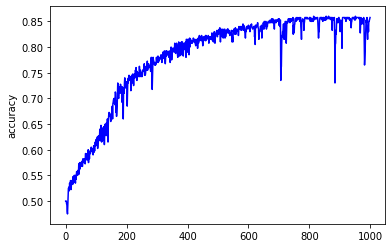

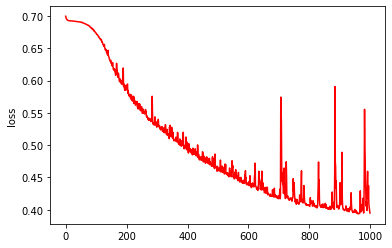

In [9]:
plt.plot(history.history['accuracy'], 'b')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'], 'r')
plt.ylabel('loss')
plt.show()
